# GPU 준비

In [ ]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Fri Jun 16 06:43:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MMDetection 설치

- 환경 설정 및 다운로드

In [ ]:

!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
!pip3 install openmim
!mim install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
# mmdetection 2.x branch 로 설치
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .
import mmdet
print(mmdet.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 701.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.0+cu116 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.0+

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


- inference

In [ ]:
!mim download mmdet --config yolov3_mobilenetv2_320_300e_coco --dest .
from mmdet.apis import init_detector, inference_detector

config_file = 'yolov3_mobilenetv2_320_300e_coco.py'
checkpoint_file = 'yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0') #or device='cpu' ,device='cuda:0'
result = inference_detector(model, 'demo/demo.jpg')
len(result)

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing yolov3_mobilenetv2_320_300e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MiB 85.6 MB/s eta 0:00:00
Successfully downloaded yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth to /content/mmdetection
Successfully dumped yolov3_mobilenetv2_320_300e_coco.py to /content/mmdetection
load checkpoint from local path: yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth


80

# 데이터 준비

- 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 데이터 복사

In [ ]:
!cp -r "/content/drive/MyDrive/Final Proejct/최종_Lotte-MEGA" /content
!cp -r "/content/drive/MyDrive/Final Proejct/New_sample" /content
!mkdir -p /content/Samples
!mkdir -p /content/Samples/label_data
!mkdir -p /content/Samples/label_data_meta
!mkdir -p /content/Samples/label_data_nonemeta
!mkdir -p /content/Samples/origin_images

In [ ]:
import os
import glob
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt

- 데이터 통합 및 xml파일 구분 (meta, nonemeta)

In [ ]:
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
      # os.walk: 시작 경로를 기준으로 하위 디렉토리를 재귀적으로 탐색하며, 각 디렉토리에서는 해당 디렉토리의 하위 파일들도 함께 반환합니다.
        count += len(files)
    return count

In [ ]:
#폴더를 순회 하면서 그림파일 및 xml 데이터 복사하기

folder1 = '/content/New_sample/라벨링데이터'
folder2 = '/content/New_sample/원천데이터'

# 복사할 이미지 파일의 대상 폴더 경로
target_folder_1 = '/content/Samples/label_data'
target_folder_2 = '/content/Samples/origin_images'


# source_folder를 재귀적으로 순회하면서 이미지 파일들을 복사
for root, dirs, files in os.walk(folder1):
    for file in files:
        if file.lower().endswith(('xml')):
            img_file = os.path.join(root, file)
            target_file = os.path.join(target_folder_1, file)
            shutil.copy(img_file, target_file)

for root, dirs, files in os.walk(folder2):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            img_file = os.path.join(root, file)
            target_file = os.path.join(target_folder_2, file)
            shutil.copy(img_file, target_file)

In [ ]:
# 라벨리 데이터 갯수
path = '/content/Samples/label_data'
count = count_files(path)
print(f'Total number of files in {path}: {count}')  # 1596

# 원천 데이터 갯수
path = '/content/Samples/origin_images'
count = count_files(path)
print(f'Total number of files in {path}: {count}')  # 798

Total number of files in /content/Samples/label_data: 1596
Total number of files in /content/Samples/origin_images: 798


In [ ]:
# xml 파일 확인

import xml.dom.minidom

root = '/content/Samples/label_data/'
file_name = '10091_0_m_10_meta.xml'

# Load XML file
dom = xml.dom.minidom.parse(root + file_name)
pretty_xml = dom.toprettyxml(indent="    ")

# Print the pretty-printed XML
print(pretty_xml)



<?xml version="1.0" ?>
<comp_cd>
    
  0301
  
    <identifier>
        
    
        <identifier>10091_0_m_10.jpg</identifier>
        
    
        <copyright>LOTTE Data Communication Company</copyright>
        
  
    </identifier>
    
  
    <div_cd>
        
    01
    
        <item_cd>03010100001</item_cd>
        
    
        <item_no>10091</item_no>
        
    
        <div_l>과자</div_l>
        
    
        <div_m>스낵</div_m>
        
    
        <div_s>옥수수스낵</div_s>
        
    
        <div_n>옥수수스낵</div_n>
        
    
        <comp_nm>롯데제과</comp_nm>
        
    
        <img_prod_nm>꼬깔콘고소한맛72G</img_prod_nm>
        
    
        <volume>72G</volume>
        
    
        <barcd>8801062380114</barcd>
        
    
        <width>18</width>
        
    
        <length>24</length>
        
    
        <height/>
        
    
        <nutrition_info>{&quot;1회제공량&quot;:&quot;30&quot;,&quot;총내용량(g)&quot;:&quot;72&quot;,&quot;총내용량(mL)&quot;:&quot;0&quot;,&quot;에너지(㎉)&

In [ ]:
# meta xml 파일만 복사
# xml파일이 두종류가 있고 meta는 표준 voc xml 파일, 그냥 파일은 표준 voc xml 파일이 아니다.
import os
import shutil

folder_1 = '/content/Samples/label_data'
target_folder = '/content/Samples/label_data_meta'

# Iterate over all files in the source directory
for filename in os.listdir(folder_1):
    if 'meta' in filename:
        source_file = os.path.join(folder_1, filename)
        destination_file = os.path.join(target_folder, filename)
        shutil.copy2(source_file, destination_file)

In [ ]:
# none meta xml 파일만 복사
# xml파일이 두종류가 있고 meta는 표준 voc xml 파일, 그냥 파일은 표준 voc xml 파일이 아니다.
import os
import shutil

folder_1 = '/content/Samples/label_data'
target_folder = '/content/Samples/label_data_nonemeta'

# Iterate over all files in the source directory
for filename in os.listdir(folder_1):
    if not 'meta' in filename:
        source_file = os.path.join(folder_1, filename)
        destination_file = os.path.join(target_folder, filename)
        shutil.copy2(source_file, destination_file)

# XML To JSON 변환
- voc 포맷을 coco 포맷으로 변환하는 패키지
- https://github.com/yukkyo/voc2coco.git 의 How to use 참고

- 환경 설정

In [ ]:
# name tag 정보를 받아오기 위해 설치
!apt-get install -y xmlstarlet
# 온라인 파서 이용 http://json.parser.online.fr/ 또는 jq 유틸리티 설치
!sudo apt-get install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xmlstarlet
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 267 kB of archives.
After this operation, 624 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 xmlstarlet amd64 1.6.1-2build1 [267 kB]
Fetched 267 kB in 1s (189 kB/s)
Selecting previously unselected package xmlstarlet.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../xmlstarlet_1.6.1-2build1_amd64.deb ...
Unpacking xmlstarlet (1.6.1-2build1) ...
Setting up xmlstarlet (1.6.1-2build1) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libjq1 libonig5
The following NEW packages will be installed:
  jq libjq1 libonig5

In [ ]:
%cd '/content/Samples'

/content/Samples


In [ ]:
#voc 포맷을 coco 포맷으로 변환하는 패키지
#https://github.com/yukkyo/voc2coco.git 의 How to use 참고
!git clone https://github.com/yukkyo/voc2coco.git /content/Samples/voc2coco

Cloning into '/content/Samples/voc2coco'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 436 (delta 19), reused 11 (delta 11), pack-reused 408
Receiving objects: 100% (436/436), 214.06 KiB | 12.59 MiB/s, done.
Resolving deltas: 100% (390/390), done.


In [ ]:
!mkdir /content/Samples/MetaSet

- train, valid, test text 파일 준비

In [ ]:
# images명을 test, valid, train set으로 나누기

import os
import random

# 이미지 파일에서 추출하는게 정확하나 현재 meta.xml 파일을 읽어야 해서 일단
# meta.xml 파일을 불러왔다

# 이미지 폴더 경로
image_folder = '/content/Samples/origin_images'

# 파일명을 저장할 텍스트 파일 경로
train_file = '/content/Samples/MetaSet/train.txt'
valid_file = '/content/Samples/MetaSet/valid.txt'
test_file = '/content/Samples/MetaSet/test.txt'

# 파일명에서 확장자를 제외하는 함수
def remove_extension(file_name):
    return os.path.splitext(file_name)[0]

# 이미지 폴더 내의 파일명 추출
file_names = []
for file_name in os.listdir(image_folder):
    if file_name.endswith('.jpg'):
        file_names.append(remove_extension(file_name))

# 파일명을 섞은 후 비율에 맞게 분할
random.shuffle(file_names)
total_count = len(file_names)
train_count = int(0.6 * total_count)  # 60% train
valid_count = int(0.2 * total_count)  # 20% validation
test_count = total_count - train_count - valid_count  # remaining for test

# 파일명을 각각의 파일에 저장
with open(train_file, 'w') as f:
    for file_name in file_names[:train_count]:
        f.write(file_name + '\n')

with open(valid_file, 'w') as f:
    for file_name in file_names[train_count:train_count+valid_count]:
        f.write(file_name + '\n')

with open(test_file, 'w') as f:
    for file_name in file_names[train_count+valid_count:]:
        f.write(file_name + '\n')

print('파일명이 성공적으로 저장되었습니다.')

파일명이 성공적으로 저장되었습니다.


In [ ]:
!cd /content/Samples

In [ ]:
# xml 파일 확인

import xml.dom.minidom

root = '/content/Samples/label_data/'
file_name = '10060_0_m_10_meta.xml'

# Load XML file
dom = xml.dom.minidom.parse(root + file_name)
pretty_xml = dom.toprettyxml(indent="    ")

# Print the pretty-printed XML
print(pretty_xml)

<?xml version="1.0" ?>
<comp_cd>
    
  1496
  
    <identifier>
        
    
        <identifier>10060_0_m_10.jpg</identifier>
        
    
        <copyright>LOTTE Data Communication Company</copyright>
        
  
    </identifier>
    
  
    <div_cd>
        
    01
    
        <item_cd>14960100001</item_cd>
        
    
        <item_no>10060</item_no>
        
    
        <div_l>과자</div_l>
        
    
        <div_m>비스킷</div_m>
        
    
        <div_s>스틱과자</div_s>
        
    
        <div_n>스틱과자</div_n>
        
    
        <comp_nm>해태제과식품</comp_nm>
        
    
        <img_prod_nm>해태포키블루베리41G</img_prod_nm>
        
    
        <volume>41G</volume>
        
    
        <barcd>8801019311345</barcd>
        
    
        <width>9</width>
        
    
        <length>9</length>
        
    
        <height>16</height>
        
    
        <nutrition_info>{&quot;1회제공량&quot;:&quot;41&quot;,&quot;총내용량(g)&quot;:&quot;41&quot;,&quot;총내용량(mL)&quot;:&quot;0&quot;,&qu

In [ ]:
!cd /content/Samples

In [ ]:
# 텍스트 파일 생성: annotation tag 종류 확인
!grep -REoh '<name>[^<]*</name>' /content/Samples/label_data_meta | sort | uniq
# 해태포키 블루베리, 꼬칼곤 고소한맛

# 텍스트 파일 생성:
!grep -ERoh '<name>[^<]*</name>' /content/Samples/label_data_meta | sed -e 's/<name>//g' -e 's/<\/name>//g' | sort | uniq > /content/Samples/labels.txt
# 파일 경로 위치 확인 할 것

<name>해태포키블루베리41G</name>
<name>크라운)콘초66G</name>
<name>꼬깔콘고소한맛72G</name>
<name>농심바나나킥75G</name>
<name>농심오징어집83G</name>
<name>농심매운새우깡90G</name>
<name>롯데)자일리톨베타비타D용기86G</name>


- JSON 파일 생성

In [ ]:
!python /content/Samples/voc2coco/voc2coco.py --ann_dir /content/Samples/label_data \
--ann_ids /content/Samples/MetaSet/test.txt \
--labels /content/Samples/labels.txt \
--output /content/Samples/test.json \
--ext xml

!python /content/Samples/voc2coco/voc2coco.py --ann_dir /content/Samples/label_data \
--ann_ids /content/Samples/MetaSet/train.txt \
--labels /content/Samples/labels.txt \
--output /content/Samples/train.json \
--ext xml

!python /content/Samples/voc2coco/voc2coco.py --ann_dir /content/Samples/label_data \
--ann_ids /content/Samples/MetaSet/valid.txt \
--labels /content/Samples/labels.txt \
--output /content/Samples/valid.json \
--ext xml

Start converting !
100% 161/161 [00:00<00:00, 15587.53it/s]
Start converting !
100% 478/478 [00:00<00:00, 15043.61it/s]
Start converting !
100% 159/159 [00:00<00:00, 15671.35it/s]


In [ ]:
!mkdir -p /content/Samples/voc2coco/Annotations
!mkdir -p /content/Samples/voc2coco/dataset_ids

In [ ]:
# Annotations와 dataset ids 파일 복사해서 옮기는 방법

# 복사할 이미지 파일이 들어있는 두 폴더 경로
folder1 = '/content/Samples/label_data'

# 복사할 이미지 파일의 대상 폴더 경로
target_folder = '/content/Samples/voc2coco/Annotations'

# source_folder를 재귀적으로 순회하면서 이미지 파일들을 복사
for root, dirs, files in os.walk(folder1):
    for file in files:
        if file.lower().endswith(('.xml')): # 파일명을 모두 소문자로 변환해 대소문자 구분 없이 검색할수 있도록 한다.
            annotation_file = os.path.join(root, file)
            target_file = os.path.join(target_folder, file)
            shutil.copy(annotation_file, target_file)

In [ ]:
# Annotation 파일
path = '/content/Samples/voc2coco/Annotations'
count = count_files(path)
print(f'Total number of files in {path}: {count}') # 1596

Total number of files in /content/Samples/voc2coco/Annotations: 1596


In [ ]:
# Annotations와 dataset ids 파일 복사해서 옮기는 방법

# 복사할 이미지 파일이 들어있는 두 폴더 경로
folder1 = '/content/Samples/MetaSet'

# 복사할 이미지 파일의 대상 폴더 경로
target_folder = '/content/Samples/voc2coco/dataset_ids'

# source_folder를 재귀적으로 순회하면서 이미지 파일들을 복사
for root, dirs, files in os.walk(folder1):
    for file in files:
        if file.lower().endswith(('.txt')): # 파일명을 모두 소문자로 변환해 대소문자 구분 없이 검색할수 있도록 한다.
            text_file = os.path.join(root, file)
            target_file = os.path.join(target_folder, file)
            shutil.copy(text_file, target_file)

In [ ]:
# Text 파일
path = '/content/Samples/voc2coco/dataset_ids'
count = count_files(path)
print(f'Total number of files in {path}: {count}') # 3

Total number of files in /content/Samples/voc2coco/dataset_ids: 3


In [ ]:
!cat /content/Samples/train.json

{"images": [{"file_name": "10091_0_m_17.jpg", "height": 2988, "width": 2988, "id": "10091_0_m_17"}, {"file_name": "10095_0_m_6.jpg", "height": 2988, "width": 2988, "id": "10095_0_m_6"}, {"file_name": "10095_30_m_4.jpg", "height": 2988, "width": 2988, "id": "10095_30_m_4"}, {"file_name": "10091_0_s_18.jpg", "height": 2988, "width": 2988, "id": "10091_0_s_18"}, {"file_name": "10093_30_s_13.jpg", "height": 2988, "width": 2988, "id": "10093_30_s_13"}, {"file_name": "10060_30_m_13.jpg", "height": 2988, "width": 2988, "id": "10060_30_m_13"}, {"file_name": "10095_30_s_14.jpg", "height": 2988, "width": 2988, "id": "10095_30_s_14"}, {"file_name": "10091_30_s_3.jpg", "height": 2988, "width": 2988, "id": "10091_30_s_3"}, {"file_name": "10091_30_m_14.jpg", "height": 2988, "width": 2988, "id": "10091_30_m_14"}, {"file_name": "10093_30_m_22.jpg", "height": 2988, "width": 2988, "id": "10093_30_m_22"}, {"file_name": "10100_60_s_9.jpg", "height": 2988, "width": 2988, "id": "10100_60_s_9"}, {"file_name"

In [ ]:
!jq . /content/Samples/train.json > output.json  # jq로 파일을 읽으면 한줄이 여러줄로 정리되어 나온다.
!tail -100 output.json

    },
    {
      "area": 1426684,
      "iscrowd": 0,
      "bbox": [
        1112,
        312,
        812,
        1757
      ],
      "category_id": 4,
      "ignore": 0,
      "segmentation": [],
      "image_id": "10095_30_m_8",
      "id": 833
    },
    {
      "area": 1469296,
      "iscrowd": 0,
      "bbox": [
        1516,
        314,
        701,
        2096
      ],
      "category_id": 4,
      "ignore": 0,
      "segmentation": [],
      "image_id": "10095_30_m_8",
      "id": 834
    },
    {
      "area": 3823563,
      "iscrowd": 0,
      "bbox": [
        540,
        316,
        1857,
        2059
      ],
      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "10094_30_s_12",
      "id": 835
    },
    {
      "area": 2583824,
      "iscrowd": 0,
      "bbox": [
        847,
        104,
        967,
        2672
      ],
      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "10094_30_s_8",
    

# 이미지와 레이블 보기

[{'class_name': '해태포키블루베리41G', 'bndbox_coor': (267, 481, 1277, 2507)}, {'class_name': '해태포키블루베리41G', 'bndbox_coor': (1103, 591, 1822, 2254)}]


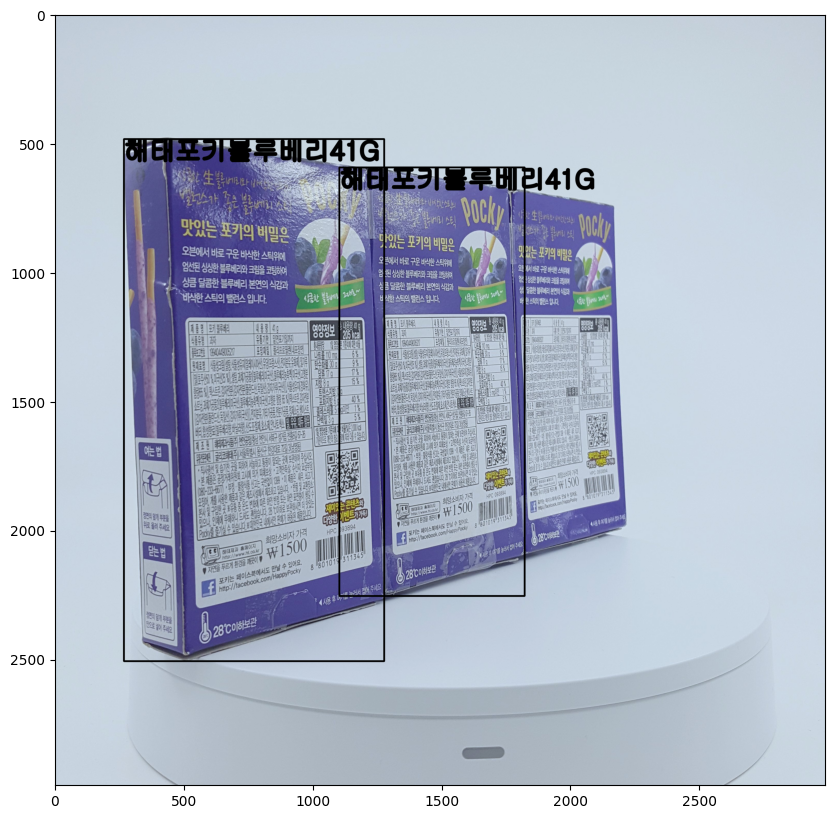

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from PIL import ImageFont, ImageDraw, Image


img_dir = "/content/Samples/origin_images"
xml_file = "/content/Samples/label_data/10060_0_m_10.xml"

class2color = {'해태포키블루베리41G':(0, 0, 0), '크라운)콘초66G':(255, 0, 255),
               '꼬깔콘고소한맛72G':(0, 255, 255),'농심바나나킥75G':(0, 255, 255),
               '농심오징어집83G':(0, 255, 255),'농심매운새우깡90G':(0, 255, 255),
               '롯데)자일리톨베타비타D용기86G':(255, 255, 0)}

tree = ET.parse(xml_file)
root = tree.getroot()

img_path = root.find('filename').text
img_full_path = os.path.join(img_dir, img_path)
img = cv2.imread(img_full_path)
dst = img.copy()

objects = root.findall('object')
object_list = []

for obj in objects:
  box = obj.find("bndbox")
  x1 = int(box.find('xmin').text)
  y1 = int(box.find('ymin').text)
  x2 = int(box.find('xmax').text)
  y2 = int(box.find('ymax').text)

  bndbox_coor = (x1, y1, x2, y2)
  class_name = obj.find("name").text

  cv2.rectangle(dst, (x1, y1), (x2, y2), color=class2color[class_name], thickness=5)

  # Convert image to PIL Image
  pil_img = Image.fromarray(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
  draw = ImageDraw.Draw(pil_img)

  # Load a font file containing Korean characters
  font_path = "/content/Gulim.ttf"
  font_size = 100
  font = ImageFont.truetype(font_path, font_size)

  # Draw Korean text on the image
  draw.text((x1, y1-5), class_name, font=font, fill=(0, 0, 0), stroke_width=5)

  # Convert the PIL Image back to OpenCV format
  dst = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

  object_dict = {'class_name' : class_name, 'bndbox_coor' : bndbox_coor}
  object_list.append(object_dict)

print(object_list)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [ ]:
# Check the label of a single image
!cat /content/Samples/label_data/10060_0_m_1.xml

<annotation><folder>/119.상품 이미지 데이터/01.데이터/1.Training/원천데이터/과자/10060_해태포키블루베리41G/</folder><filename>10060_0_m_1.jpg</filename><path>/119.상품 이미지 데이터/01.데이터/1.Training/원천데이터/과자/10060_해태포키블루베리41G/10060_0_m_1.jpg</path><source><database>Unknown</database></source><size><width>2988</width><height>2988</height><depth>3</depth></size><segmented>0</segmented><object><name>해태포키블루베리41G</name><pose>Unspecified</pose><truncated>0</truncated><difficult>0</difficult><bndbox><xmin>111</xmin><ymin>597</ymin><xmax>1075</xmax><ymax>2265</ymax></bndbox></object><object><name>해태포키블루베리41G</name><pose>Unspecified</pose><truncated>0</truncated><difficult>0</difficult><bndbox><xmin>1058</xmin><ymin>591</ymin><xmax>1942</xmax><ymax>2232</ymax></bndbox></object><object><name>해태포키블루베리41G</name><pose>Unspecified</pose><truncated>0</truncated><difficult>0</difficult><bndbox><xmin>1922</xmin><ymin>595</ymin><xmax>2841</xmax><ymax>2222</ymax></bndbox></object></annotation>

# Dataset COCO Format 변환

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class SnacksDataset(CocoDataset):
    CLASSES = ('해태포키블루베리41G', '크라운)콘초66G', '꼬깔콘고소한맛72G',
               '농심바나나킥75G', '농심오징어집83G', '농심매운새우깡90G', '롯데)자일리톨베타비타D용기86G')

- Pretrained model download

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py')
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth \
      -O checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth

--2023-06-16 08:55:01--  https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.82.215, 163.181.82.212, 163.181.82.214, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.82.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152149505 (145M) [application/octet-stream]
Saving to: ‘checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth’

checkpoints/retinan 100%[===================>] 145.10M  37.4MB/s    in 4.8s    

2023-06-16 08:55:06 (30.1 MB/s) - ‘checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth’ saved [152149505/152149505]



In [ ]:
%pwd

'/content/Samples'

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'SnacksDataset'
cfg.data_root = '/content/Samples'

cfg.data.test.type = 'SnacksDataset'
cfg.data.test.data_root = '/content/Samples/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'origin_images'

cfg.data.train.type = 'SnacksDataset'
cfg.data.train.data_root = '/content/Samples/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'origin_images'

cfg.data.val.type = 'SnacksDataset'
cfg.data.val.data_root = '/content/Samples/'
cfg.data.val.ann_file = 'valid.json'
cfg.data.val.img_prefix = 'origin_images'

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 7
#cfg.model.roi_head.mask_head.num_classes = 6

# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/Final Proejct'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.0001 / 8 # lr = 0.01일때 학습이 되지않아 (nan) 0.001로 변경
# cfg.lr_config.warmup = None
cfg.log_config.interval = 7

# max epochs 12
# cfg.runner.max_epochs = 12 # 기본값 변경시에만 설정

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨)
# samples_per_gpu 2
# cfg.data.samples_per_gpu = 2 # 기본값 변경시에만설정

# Change the evaluation metric since we use customized dataset.
# note.
# detection evaluation에 map를 설정하면 iou가 0.5 일때만
# cocodata로 detection 할 때는 bbox를 설정해야 다양한 iou 기준 출력
# cocodata로 segmentation 할때는 bbox, segm을 지정
# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
#cfg.evaluation.metric = ['bbox', 'segm'] # segm이 없으므로 segm을 제외하고 실행 이 파일은 segm을 포함하고 돌려서 결과에서 에러가 발생함
cfg.evaluation.metric = ['bbox']

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 10
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 6

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.device = 'cuda'
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

- Config에서 설정한 Snacks Dataset 적용

In [ ]:
from mmdet.datasets import build_dataset

# Build dataset
train_dataset, test_dataset = [build_dataset(cfg.data.train), build_dataset(cfg.data.test)]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
from mmdet.models import build_detector

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = train_dataset.CLASSES

In [ ]:
import mmcv
from mmdet.apis import train_detector

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_detector(model, train_dataset, cfg, distributed=False, validate=True)

2023-06-16 08:01:22,019 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-06-16 08:01:22,028 - mmdet - INFO - load checkpoint from local path: checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
2023-06-16 08:01:22,062 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.layer5.0.expand_conv.conv.weight, backbone.layer5.0.expand_conv.bn.weight, backbone.layer5.0.expand_conv.bn.bias, backbone.layer5.0.expand_conv.bn.running_mean, backbone.layer5.0.expand_conv.bn.running_var, backbone.layer5.0.expand_conv.bn.num_batches_tracked, backbone.layer5.0.depthwise_conv.conv.weight, backbone.layer5.0.depthwise_conv.bn.weight, backbone.layer5.0.depthwise_conv.bn.bias, backbone.layer5.0.depthwise_conv.bn.running_mean, backbone.layer5.0.depthwise_conv.bn.running_var, backbone.layer5.0.depthwise_conv.bn.num_batches_tracked, backbone.layer5.0.linear_conv.conv.weight, backbone.layer5.0.linear_conv.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2023-06-16 08:01:27,581 - mmdet - INFO - Epoch [1][7/239]	lr: 1.623e-07, eta: 0:36:42, time: 0.770, data_time: 0.383, memory: 4499, loss_cls: 3692.4762, loss_bbox: 0.6657, loss: 3693.1419
2023-06-16 08:01:30,424 - mmdet - INFO - Epoch [1][14/239]	lr: 3.372e-07, eta: 0:27:57, time: 0.406, data_time: 0.049, memory: 4499, loss_cls: 2050.0498, loss_bbox: 0.6870, loss: 2050.7367
2023-06-16 08:01:33,268 - mmdet - INFO - Epoch [1][21/239]	lr: 5.120e-07, eta: 0:25:02, time: 0.408, data_time: 0.044, memory: 4499, loss_cls: 856.1780, loss_bbox: 0.6803, loss: 856.8583
2023-06-16 08:01:36,032 - mmdet - INFO - Epoch [1][28/239]	lr: 6.868e-07, eta: 0:23:23, time: 0.394, data_time: 0.027, memory: 4499, loss_cls: 74.6902, loss_bbox: 0.6598, loss: 75.3500
2023-06-16 08:01:38,570 - mmdet - INFO - Epoch [1][35/239]	lr: 8.617e-07, eta: 0:22:05, time: 0.362, data_time: 0.028, memory: 4499, loss_cls: 34.1277, loss_bbox: 0.7232, loss: 34.8509
2023-06-16 08:01:41,087 - mmdet - INFO - Epoch [1][42/239]	lr: 1.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 159/159, 7.0 task/s, elapsed: 23s, ETA:     0s

2023-06-16 08:18:26,032 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...


2023-06-16 08:18:26,776 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=

DONE (t=0.27s).


2023-06-16 08:18:32,971 - mmdet - INFO - Epoch [11][7/239]	lr: 1.250e-06, eta: 0:03:16, time: 0.864, data_time: 0.481, memory: 4499, loss_cls: 1.2730, loss_bbox: 0.5971, loss: 1.8701
2023-06-16 08:18:36,015 - mmdet - INFO - Epoch [11][14/239]	lr: 1.250e-06, eta: 0:03:13, time: 0.438, data_time: 0.051, memory: 4499, loss_cls: 1.3311, loss_bbox: 0.5510, loss: 1.8821
2023-06-16 08:18:38,893 - mmdet - INFO - Epoch [11][21/239]	lr: 1.250e-06, eta: 0:03:10, time: 0.408, data_time: 0.032, memory: 4499, loss_cls: 1.1590, loss_bbox: 0.5061, loss: 1.6652
2023-06-16 08:18:41,579 - mmdet - INFO - Epoch [11][28/239]	lr: 1.250e-06, eta: 0:03:07, time: 0.384, data_time: 0.025, memory: 4499, loss_cls: 1.1283, loss_bbox: 0.5646, loss: 1.6929
2023-06-16 08:18:44,266 - mmdet - INFO - Epoch [11][35/239]	lr: 1.250e-06, eta: 0:03:04, time: 0.383, data_time: 0.025, memory: 4499, loss_cls: 1.1313, loss_bbox: 0.5542, loss: 1.6855
2023-06-16 08:18:46,984 - mmdet - INFO - Epoch [11][42/239]	lr: 1.250e-06, eta: 0

In [ ]:
# 실행 중 한글로 되어 있는 폴더 명에 colab이 접근을 못하여 !ls 함수를 이용해 접근 여부를 확인함
!ls '/content/Samples/original_data'


# 학습된 모델로 예측

In [ ]:
from mmdet.apis import show_result_pyplot

checkpoint_file = '//content/drive/MyDrive/Final Proejct/0616_0524epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용.
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: //content/drive/MyDrive/Final Proejct/0616_0524epoch_12.pth


In [ ]:
'''
from mmdet.apis import show_result_pyplot

checkpoint_file = '//content/drive/MyDrive/Final Proejct/0616_0524epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용.
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')
img = mmcv.imread('/content/mmdetection/hard-hat-detection/images/hard_hat_workers10.png') # BGR Image 사용
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.4)

- 이미지 한장 예측

In [ ]:
from mmdet.apis import show_result_pyplot

img = mmcv.imread('/content/Samples/origin_images/10060_0_m_1.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.2)

NameError: ignored

- 이미지 여러장 예측

# 모델 평가

In [ ]:
from mmdet.datasets import build_dataloader, build_dataset

data_loader = build_dataloader(
        test_dataset,
        samples_per_gpu=1, #cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

next(iter(data_loader))

In [ ]:
from mmdet.apis import single_gpu_test
from mmdet.utils import build_dp

# 위에서 만든 /content/show_test_output 디렉토리에 예측 이미지가 저장됨.
model_ckpt = build_dp(model_ckpt, cfg.device, device_ids=cfg.gpu_ids)
results = single_gpu_test(model_ckpt, data_loader, True, '/content/show_test_output', 0.3)

[                                                  ] 0/161, elapsed: 0s, ETA:

/content/mmdetection/mmdet/core/visualization/image.py:353: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  stream, _ = canvas.print_to_buffer()
/content/mmdetection/mmdet/core/visualization/image.py:353: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  stream, _ = canvas.print_to_buffer()
/content/mmdetection/mmdet/core/visualization/image.py:353: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  stream, _ = canvas.print_to_buffer()
/content/mmdetection/mmdet/core/visualization/image.py:353: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from current font.
  stream, _ = canvas.print_to_buffer()
/content/mmdetection/mmdet/core/visualization/image.py:353: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from current font.
  stream, _ = canvas.print_to_buffer()
/content/mmdetection/mmdet/core/visualization/image.py:353: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 161/161, 0.6 task/s, elapsed: 267s, ETA:     0s

In [ ]:
metric = test_dataset.evaluate(results, metric='bbox')
print(metric)


Evaluating bbox...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.28s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.